# Statistical Distribution Assessment (Bootstrap & Jackknife)

The Central Limit Theorem, which is at the heart of interval estimation problem, postulates that the estimates of the mean from a sample tend to become Normally distributed as the sample size (n) increases. This generally holds for any population distribution if n is greater than or equal to 30.  The theorem can even hold in the case of smaller samples, if the original population has a Normal-like distribution.

Now suppose the data is drawn from a population with a completely unknown distribution and the sample size is less than 30. In this case, the Central Limit Theorem does not hold. Therefore, t and z disrtributions/scores cannot be used to find intervals for point estimates. We can still use the sample mean x as a point estimate of µ. But how can one find a confidence interval for µ around x? One answer is to use the bootstrap! 

In [3]:
# Load relevant R packages
inLibraries = list('repr','rgdal','sp','rgeos','bootstrap','classInt','RColorBrewer','MASS')
for (rpack in inLibraries) {
  if (is.element(rpack,installed.packages()[,1])){           
      #Load the library into R
      suppressMessages(library(rpack,character.only = TRUE))
    }
    else {
        print(paste("Warning:  ",rpack," is not an installed package"))
    }
}
#resize plot area
options(repr.plot.width=6, repr.plot.height=6)

## Read Observed Measurements

We will use observations of minimum temperature at 19 weather stations over the state of Missouri. The station point locations can be found at (weatherdata/WeatherMO.shp) and state boundaries that can be used for spatial context can be found at (weatherdata/states_polygon.shp). The minimum temperature attribute in the station dataset is named 'lowTemp' and was derived from a single day's weather information obtained from: https://www.wunderground.com/. 

In [5]:
# Read in shp files
inFeature.pts <- readOGR("datasets/weatherdata","WeatherMO")

OGR data source with driver: ESRI Shapefile 
Source: "datasets/weatherdata", layer: "WeatherMO"
with 19 features
It has 19 fields
Integer64 fields read as strings:  day month year period highTemp lowTemp avewindSpe avewindDeg avehumidit RASTERVALU elevation 


In [6]:
inFeature.polys <- readOGR("datasets/weatherdata","states_polygon")

OGR data source with driver: ESRI Shapefile 
Source: "datasets/weatherdata", layer: "states_polygon"
with 9 features
It has 9 fields


In [7]:
peek1 <- head(inFeature.pts@data, 3)

t(peek1)

,1,2,3
state,MO,MO,MO
city,Kirksville,Chillicothe,Saint Joseph
day,13,13,13
month,7,7,7
year,2017,2017,2017
period,1,1,1
highTemp,87,85,83
lowTemp,63,67,67
conditions,Partly Cloudy,Thunderstorm,Chance of a Thunderstorm
qpf_allday,0.00,0.02,0.39


In [8]:
peek2 <- head(inFeature.polys@data, 3)

t(peek2)

,0,1,2
STATEFP,20,29,40
STATENS,00481813,01779791,01102857
AFFGEOID,0400000US20,0400000US29,0400000US40
GEOID,20,29,40
STUSPS,KS,MO,OK
NAME,Kansas,Missouri,Oklahoma
LSAD,00,00,00
ALAND,211753253104,178052653610,177663722167
AWATER,1346235678,2487575477,3373836066


In [9]:
# Define analysis variable
inVa <- as.numeric (inFeature.pts$lowTemp)

In [10]:
inVa[1:5]

[1] 1 2 2 5 4

## Explore the Feature Attributes

In [11]:
# Summarize attributes of weather data
summary (inFeature.pts)

Object of class SpatialPointsDataFrame
Coordinates:
                min       max
coords.x1  342407.8  804839.4
coords.x2 4071401.4 4448930.1
Is projected: TRUE 
proj4string :
[+proj=utm +zone=15 +datum=NAD83 +units=m +no_defs +ellps=GRS80
+towgs84=0,0,0]
Number of points: 19
Data attributes:
 state                  city    day     month    year    period    highTemp
 MO:19   Cape Girardeau   : 1   13:19   7:19   2017:19   1:19   89     :3  
         Chesterfield     : 1                                   93     :3  
         Chillicothe      : 1                                   91     :2  
         Columbia         : 1                                   92     :2  
         Farmington       : 1                                   97     :2  
         Fort Leonard Wood: 1                                   83     :1  
         (Other)          :13                                   (Other):6  
 lowTemp                    conditions   qpf_allday       snow_allda
 63:1    Chance of a Thunders

In [12]:
# Summarize attributes of the state polygon
summary (inFeature.polys)

Object of class SpatialPolygonsDataFrame
Coordinates:
         min      max
x -104.05351 -81.6469
y   33.00411  43.5012
Is projected: FALSE 
proj4string :
[+proj=longlat +datum=NAD83 +no_defs +ellps=GRS80 +towgs84=0,0,0]
Data attributes:
    STATEFP      STATENS         AFFGEOID     GEOID       STUSPS        NAME  
 05     :1   00068085:1   0400000US05:1   05     :1   AR     :1   Arkansas:1  
 17     :1   00481813:1   0400000US17:1   17     :1   IA     :1   Illinois:1  
 19     :1   01102857:1   0400000US19:1   19     :1   IL     :1   Iowa    :1  
 20     :1   01325873:1   0400000US20:1   20     :1   KS     :1   Kansas  :1  
 21     :1   01779784:1   0400000US21:1   21     :1   KY     :1   Kentucky:1  
 29     :1   01779785:1   0400000US29:1   29     :1   MO     :1   Missouri:1  
 (Other):3   (Other) :3   (Other)    :3   (Other):3   (Other):3   (Other) :3  
 LSAD       ALAND               AWATER         
 00:9   Min.   :1.023e+11   Min.   :1.078e+09  
        1st Qu.:1.348e+11   1st Qu

### Align CRS

As could be seen from features summary, our point and polygon features have different coordinate systems so one should be transform to the other. To do so, the spTransform () function (sp library) can be used.

In [13]:
# Transform to utm
inFeature.polys <- spTransform(inFeature.polys, 
                               CRS("+proj=utm +zone=15 +datum=NAD83 +units=m +no_defs +ellps=GRS80 +towgs84=0,0,0"))

In [14]:
summary(inFeature.polys)

Object of class SpatialPolygonsDataFrame
Coordinates:
        min     max
x -430361.5 1517175
y 3652561.8 4822687
Is projected: TRUE 
proj4string :
[+proj=utm +zone=15 +datum=NAD83 +units=m +no_defs +ellps=GRS80
+towgs84=0,0,0]
Data attributes:
    STATEFP      STATENS         AFFGEOID     GEOID       STUSPS        NAME  
 05     :1   00068085:1   0400000US05:1   05     :1   AR     :1   Arkansas:1  
 17     :1   00481813:1   0400000US17:1   17     :1   IA     :1   Illinois:1  
 19     :1   01102857:1   0400000US19:1   19     :1   IL     :1   Iowa    :1  
 20     :1   01325873:1   0400000US20:1   20     :1   KS     :1   Kansas  :1  
 21     :1   01779784:1   0400000US21:1   21     :1   KY     :1   Kentucky:1  
 29     :1   01779785:1   0400000US29:1   29     :1   MO     :1   Missouri:1  
 (Other):3   (Other) :3   (Other)    :3   (Other):3   (Other):3   (Other) :3  
 LSAD       ALAND               AWATER         
 00:9   Min.   :1.023e+11   Min.   :1.078e+09  
        1st Qu.:1.348e+11  

## Visualize Features

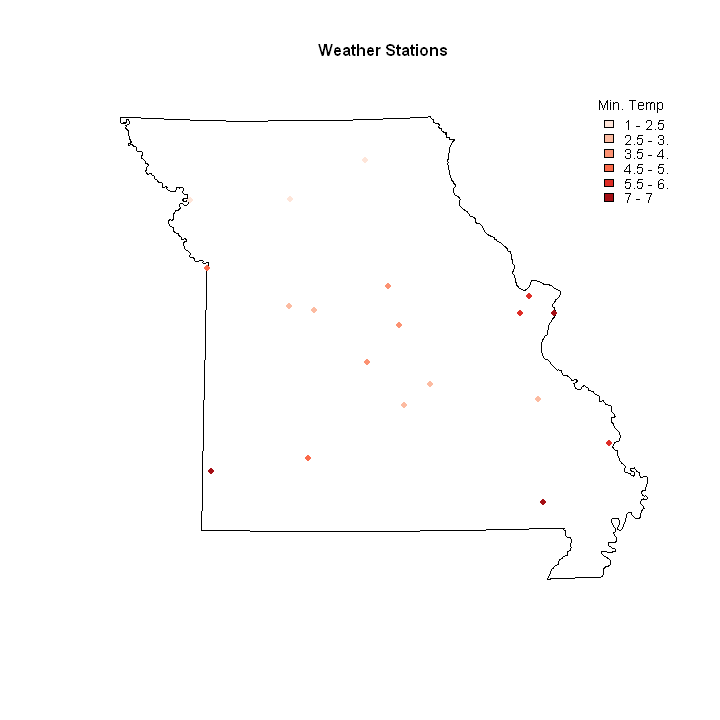

In [15]:
#Configure classification parameters
numcat <- 6
cate <- classIntervals(inVa, numcat, style = "kmeans")

#assign colors to categories
pal <- brewer.pal(numcat, "Reds")
cols <- findColours(cate, pal)

# Map input data
plot(inFeature.polys[inFeature.polys$NAME == "Missouri", ], 
             col = "white",
             main = "Weather Stations",
             cex.main = 0.8)


plot(inFeature.pts, 
             col = cols, 
             pch = 20,
             add = TRUE)

#map classification scheme
decimalPlaces <- 3

brks.dec <- round(cate$brks,decimalPlaces)

leg.text <- paste(brks.dec[-numcat], brks.dec[-1], sep=" - ")

legend("topright", fill = attr(cols,"palette"), 
               legend = leg.text, 
               bty = "n", 
               title = "Min. Temp",             
               cex = 0.7)

## Descriptive statistics

Let's say we have sampled to estimate mean and variance of minimum temperature in Missouri. First, examine the sample estimate for the statistics of interest (mean and variance). This task can be accomplished using the mean() and var() functions.

In [16]:
# find mean and variance of sample
mean (inVa)

var (inVa)

[1] 4.263158

[1] 3.426901

### Sample Distribution

The next step is to look at the sample distribution. Though resampling methods do not require any assumptions regarding the shape/distribution of data, the histogram and normality can be examined.  In practice, the sample data may be small and not normally distributed. In such instances, estimate intervals cannot be validly computed based on the Central Limit Theorem . As can be seen, the histogram and qq-plot don't reflect a normal distribution.

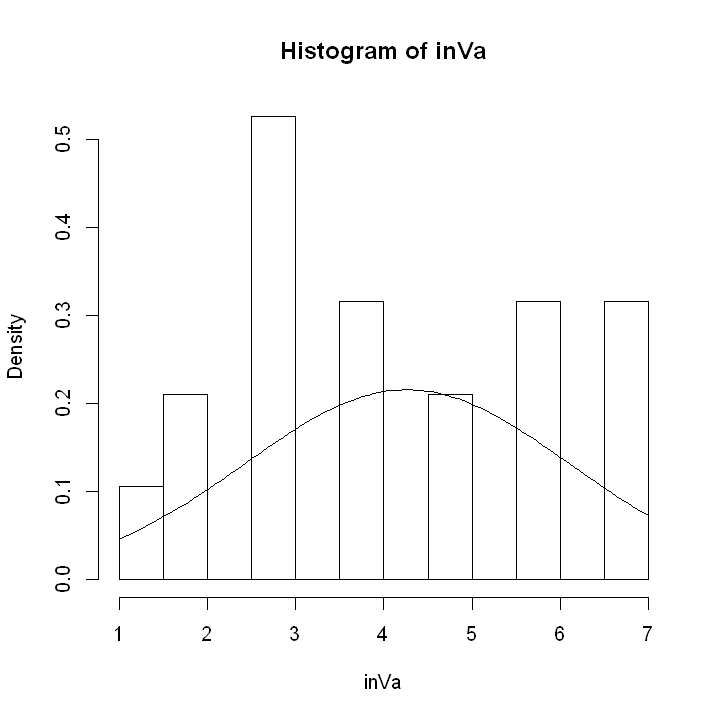

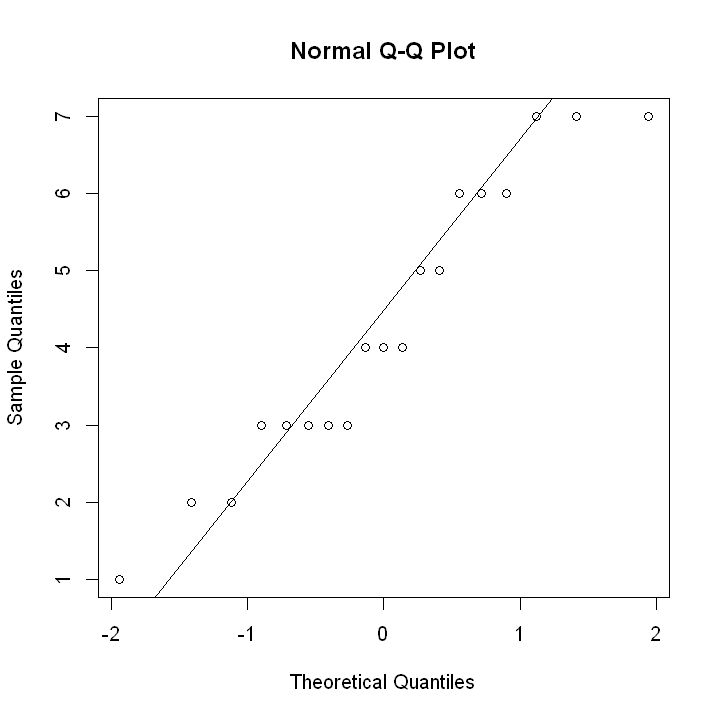

In [17]:
# Draw the histogram and normal distribution line
hist(inVa, freq = FALSE, breaks=12)

curve(dnorm(x, mean = mean(inVa), sd = sd(inVa)), 
                                          add = T)

# Draw the qq plot
qqnorm(inVa)

# fit the line
qqline(inVa)

### Shapiro Test

The shapiro test rejects the null hypothesis (data is normal) at 5% significance level (p-value = 0.02 < 0.05) which implies that the data does not have a normal distribution. It is worth noting that according to central limit theorem (for large samples, >= 30) the mean distribution of samples has a normal distribution though the original sample might not be normal. But the sample has only 19 observations and as such, the assumptions required for  the Central Limit Theorem are invalid. Therefore, the only way to construct estimate intervals is via resampling! 

In [18]:
# conduct sahpiro test
shapiro.test (inVa)


	Shapiro-Wilk normality test

data:  inVa
W = 0.93163, p-value = 0.1855


### Bootstrapping (estimation of mean)

Bootstrapping is one way to perform computations on the data itself to estimate the variation of statistics that are themselves computed from the same data. That is, the data is "pulling itself up by its own bootstrap." The bootstrap() function (bootstrap library) can be used to accomplish this. The bootstrap() function requires the input variable, number of samples, and the functional form of the variable. The bootstrap result shows the mean estimate of _____ and standard deviation of ____ for 1000 samples. For confidence level of 95% (significance level of 5%), the mean estimation is between _____ and _____ and for 90% confidence level (significance level of 10%), the mean estimation range narrows to _____ and _____.  

In [19]:
# Bootstrap (1000 times)
n.s <- 1000

# statistic to be estimated
f.mean <- function(x){mean(x)}

# conduct bootstrap to find sample mean distribution
bs.mean <- bootstrap(inVa, n.s, f.mean)

In [20]:
names(bs.mean)

[1] "thetastar"      "func.thetastar" "jack.boot.val"  "jack.boot.se"  
[5] "call"

In [21]:
# print out mean and standard deviation of sample mean distribution
print(paste("bootstrap estimate of mean =", mean(bs.mean$thetastar)))
print(paste("standard deviation of bootstrap estimate of mean =", sd(bs.mean$thetastar)))

[1] "bootstrap estimate of mean = 4.26552631578947"
[1] "standard deviation of bootstrap estimate of mean = 0.40087504006942"


In [22]:
# Find confidence intervals for the mean estimation
conf.int <- boott(inVa,f.mean)

In [23]:
names(conf.int)

[1] "confpoints" "theta"      "g"          "call"

In [24]:
print("------------------------------------------------------------")
print("bootstrap confidence intervals for sample mean estimate")
print(conf.int$confpoints)

[1] "------------------------------------------------------------"
[1] "bootstrap confidence intervals for sample mean estimate"
       0.001     0.01    0.025    0.05      0.1      0.5      0.9     0.95
[1,] 3.25989 3.374378 3.502046 3.57961 3.675341 4.190158 4.626712 4.737847
        0.975     0.99    0.999
[1,] 4.843531 4.887922 4.907596


### Bootstrapping (estimation of variance)

The bootstrap result shows the variance estimate of ____ for samples 1000 . For confidence level of 95% (significance level of 5%), the variance estimation is between ____ and _____ and for 90% confidence level (significance level of 10%), the variance estimation ranges from _____ to _______. 

In [25]:
# Bootstrap (1000 times)
n.s <- 1000

# statistic to be estimated
f.var <- function(x){var(x)}

# conduct bootstrap to find sample variance distribution
bs.var <- bootstrap(inVa, n.s, f.var)

# print out mean and standard deviation of sample variance distribution
print (paste("bootstrap estimate of variance =", mean(bs.var$thetastar)))
print (paste("standard deviation of bootstrap estimate of variance =",sd(bs.var$thetastar)))


# Find confidence intervals for the variance estimation
conf.int <- boott(inVa,f.var)
print ("------------------------------------------------------------------------")
print ("bootstrap confidence intervals for sample variance estimate")
print (conf.int$confpoints)

[1] "bootstrap estimate of variance = 3.2549649122807"
[1] "standard deviation of bootstrap estimate of variance = 0.751545814905672"
[1] "------------------------------------------------------------------------"
[1] "bootstrap confidence intervals for sample variance estimate"
        0.001     0.01    0.025     0.05      0.1      0.5      0.9     0.95
[1,] 1.872313 2.163225 2.308177 2.515828 2.846945 3.624386 4.774639 5.255177
        0.975     0.99   0.999
[1,] 5.804667 6.645926 7.34271


## Jackknife Estimation

The Jackknife method is a simplier form of a bootstrap.  The jackknife or "leave one out" is an iterative process in which first the parameter of interest is estimated from the whole sample then each element is in turn dropped from the sample and the parameter is estimated from smaller sample. The jackknife result shows the mean estimate of _____ and standard deviation of ____ for 1000 samples. 

Again, each time this procedure is repeated, different samples are taken and the results will change.

In [26]:
#JackKnifing
jk.mean <- jackknife(inVa, f.mean)
jk.var <- jackknife(inVa, f.var)

In [27]:
names(jk.mean)

[1] "jack.se"     "jack.bias"   "jack.values" "call"

In [28]:
print (paste("jacknife estimate of mean =", mean(jk.mean$jack.values)))
print (paste("jacknife estimate of variance =", mean(jk.var$jack.values)))
print (paste("standard error of jacknife estimate of mean =", jk.mean$jack.se))
print (paste("standard error of jacknife estimate of variance =",jk.var$jack.se))

[1] "jacknife estimate of mean = 4.26315789473684"
[1] "jacknife estimate of variance = 3.42690058479532"
[1] "standard error of jacknife estimate of mean = 0.424691874979306"
[1] "standard error of jacknife estimate of variance = 0.798430877414786"
